# EE4375-2022: Second Lab Session: From scripts to functions

## Import Packages  

In [21]:
using LinearAlgebra 
using SparseArrays 

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## Section 1: Build Linear System as Sparse From the Start
Motivation 
1. build matrix as sparse directly, i.e., avoid convection from dense to sparse matrix; 
2. use code as building block for more complex cocde; 
3. profile code in terms of memory and CPU usage; 
4. unit test the code (compare with analytical solution or rate of converge); 

### Section 1.1: Build Coefficient Matrix 

In [45]:
function buildMat1D(N)
  Nm1 = N-1; Np1 = N+1 
  h = 1/N; h2 = h*h; 
  stencil = [-1/h2, 2/h2, -1/h2]; 
  #..Allocate row, column and value vector 
  I = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  J = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  vals = zeros(Float64,3*Nm1)
  #..Construct row, column and value vector 
  for i in 2:N
    offset = 3*(i-2)
    I[[offset+1, offset+2, offset+3]] = [i,i,i]
    J[[offset+1, offset+2, offset+3]] = [i-1,i,i+1]
    vals[[offset+1, offset+2, offset+3]] = stencil
  end 
  #..Build matrix for interior rows   
  A = sparse(I,J,vals,Np1,Np1)
  #..Build matrix for boundary rows
  A[1,1] = 1; A[end,end]=1; A[2,1] =0; A[end-1,end]=0; 
  return A 
end 

buildMat1D (generic function with 1 method)

In [46]:
A = buildMat1D(4);
typeof(A)

SparseMatrixCSC{Float64, Int64}

### Section 1.2: Construction of the Right-Hand Side Vector

In [34]:
function buildRhs1D(N,sourceFct)
  h = 1/N;
  x = Vector(0:h:1)
  #..Build vector for interior rows 
  f = sourceFct(x)
  #..Build matrix for boundary rows
  f[1] = 0; f[end] = 0; 
  return f 
end 

buildRhs1D (generic function with 1 method)

In [25]:
sourceFct(x)= x.*sin.(π*x)

sourceFct (generic function with 1 method)

In [35]:
f = buildRhs1D(4,sourceFct)

5-element Vector{Float64}:
 0.0
 0.17677669529663687
 0.5
 0.5303300858899107
 0.0

### Section 1.3: Solve the Linear System 

In [36]:
function solvePoisson1D(N,sourceFct)
  A = buildMat1D(N);
  f = buildRhs1D(N,sourceFct)
  u = A\f 
  return u 
end

solvePoisson1D (generic function with 1 method)

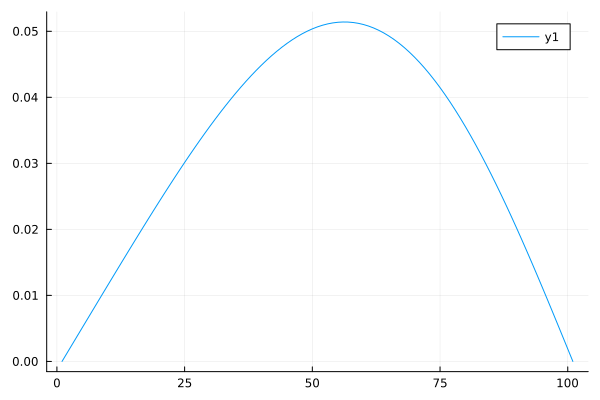

In [37]:
u = solvePoisson1D(100,sourceFct);
plot(u)

## Section 2: Code Profiling

In [47]:
@code_warntype buildMat1D(5);

MethodInstance for buildMat1D(::Int64)
  from buildMat1D(N) in Main at In[45]:1
Arguments
  #self#::Core.Const(buildMat1D)
  N::Int64
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  A::SparseMatrixCSC{Float64, Int64}
  vals::Vector{Float64}
  J::Vector{Int64}
  I::Vector{Int64}
  stencil::Vector{Float64}
  h2::Float64
  h::Float64
  Np1::Int64
  Nm1::Int64
  i::Int64
  offset::Int64
Body::SparseMatrixCSC{Float64, Int64}
1 ─       Core.NewvarNode(:(A))
│         (Nm1 = N - 1)
│         (Np1 = N + 1)
│         (h = 1 / N)
│         (h2 = h * h)
│   %6  = (-1 / h2)::Float64
│   %7  = (2 / h2)::Float64
│   %8  = (-1 / h2)::Float64
│         (stencil = Base.vect(%6, %7, %8))
│   %10 = (3 * Nm1)::Int64
│         (I = Main.zeros(Main.Int64, %10))
│   %12 = (3 * Nm1)::Int64
│         (J = Main.zeros(Main.Int64, %12))
│   %14 = (3 * Nm1)::Int64
│         (vals = Main.zeros(Main.Float64, %14))
│   %16 = (2:N)::Core.PartialStruct(UnitRange{Int64}, Any[Core.Const(2), Int64])
│         (@_3 = B

In [42]:
@code_warntype buildRhs1D(5,sourceFct)

MethodInstance for buildRhs1D(::Int64, ::typeof(sourceFct))
  from buildRhs1D(N, sourceFct) in Main at In[34]:1
Arguments
  #self#::Core.Const(buildRhs1D)
  N::Int64
  sourceFct::Core.Const(sourceFct)
Locals
  f::Vector{Float64}
  x::Vector{Float64}
  h::Float64
Body::Vector{Float64}
1 ─      (h = 1 / N)
│   %2 = (0:h:1)::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
│        (x = Main.Vector(%2))
│        (f = (sourceFct)(x))
│        Base.setindex!(f, 0, 1)
│   %6 = f::Vector{Float64}
│   %7 = Base.lastindex(f)::Int64
│        Base.setindex!(%6, 0, %7)
└──      return f



In [49]:
@code_warntype solvePoisson1D(5,sourceFct);

MethodInstance for solvePoisson1D(::Int64, ::typeof(sourceFct))
  from solvePoisson1D(N, sourceFct) in Main at In[36]:1
Arguments
  #self#::Core.Const(solvePoisson1D)
  N::Int64
  sourceFct::Core.Const(sourceFct)
Locals
  u::Vector{Float64}
  f::Vector{Float64}
  A::SparseMatrixCSC{Float64, Int64}
Body::Vector{Float64}
1 ─     (A = Main.buildMat1D(N))
│       (f = Main.buildRhs1D(N, sourceFct))
│       (u = A \ f)
└──     return u



In [33]:
@btime buildMat1D(5)

  1.012 μs (36 allocations: 3.86 KiB)


6×6 SparseMatrixCSC{Float64, Int64} with 14 stored entries:
 1.0     ⋅      ⋅      ⋅      ⋅    ⋅ 
 0.0   50.0  -25.0     ⋅      ⋅    ⋅ 
  ⋅   -25.0   50.0  -25.0     ⋅    ⋅ 
  ⋅      ⋅   -25.0   50.0  -25.0   ⋅ 
  ⋅      ⋅      ⋅   -25.0   50.0  0.0
  ⋅      ⋅      ⋅      ⋅      ⋅   1.0